#DATOS DE MERCADO DE VALORES (índice S&P 500)

##Instalando librerias 

In [27]:
# necesitamos la libreria WIKITABLES para descargar tablas de Wikipedia (y mantener actualizada la data)
# Necesitamos la libreria FSSPEC (Interfaces de sistema de archivos para Python)
# Necesitamos la libreria  beautifulsoup4 : para raspado web altamente evolucionadas
#!pip install wikitables
!pip install fsspec
!pip install beautifulsoup4 

##Importando librerias 

In [28]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D   #para graficas en 3D

import requests                           # libreria para manejar pedidos internet
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML

#from wikitables import import_tables    # para descargar tablas de Wikipedia
from sklearn.decomposition import PCA   # Análisis de componentes principales (PCA).

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##Importando el dataset

In [29]:
df = pd.read_csv("https://raw.githubusercontent.com/2HenryCardenas1/DeepLearning/main/Datasets/K_means_indice_S%2526P_500.csv")
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [30]:
df.shape

(619040, 7)

Informacion sobre el dataset

La data (CSV) tiene las siguientes columnas: Fecha - en formato: yy-mm-dd



*   OPEN-Abierto - precio de la acción en el mercado abierto (estos son datos de NYSE, así que todo en USD)
*   HIGH - Alto - Precio más alto alcanzado en el día
*   Low Close - Precio más bajo alcanzado en el día
*   Volumen - Número de acciones negociadas   
*   nombre: el nombre del ticker de la acción

##Conociendo y preparando los datos

Vamos a usar datos semanales desde 2013 a 2018, donde cada acción tiene su propio rango de valores. Por ejemplo:
 

*   Apple (APPL) empieza en $67.85

*   Adobe (ADBE) en $39.12.

---

La intención de este ejercicio es agrupar las acciones por el comportamiento de sus ganancias, en vez de por su precio de mercado. De esta forma el rendimiento de cada acción es comparable con los demás.

In [31]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

##Eliminamos datos vacios

In [32]:
df = df.dropna()   # Se eliminan filas que tengan valor NaN.
df = df.reset_index(drop=True) #Se reacomoda las filas en los espacios vacios para optimizacion de la memoria

##Cambiamos los tipos de datos para que queden todos en numeros

In [33]:
df['date']=pd.to_datetime(df['date'])       # Convertimos el campo DATE en tipo fecha
df = df.rename(columns={'Name':'symbol'})   #cambiamos el nombre la col de NAME a  SYMBOL
df.head()

,date,open,high,low,close,volume,symbol
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


#Descargamos la lista de las 500 compañias S&P

In [34]:
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"   # pagina de wikipedia donde esta la tabla
table_class="wikitable sortable jquery-tablesorter"                   # clase de la tabla
response=requests.get(wikiurl)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
indiatable=soup.find('table',{'id':"constituents"})                   # buscamos el objecto puede ser por la clase o por el ID
df_list_table=pd.read_html(str(indiatable))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df_companies=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe
df_companies.to_csv('companies.csv', index_label=False)
df_companies.head()

200


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


#Descargamos la lista de las empresas que cotizan con el índice bursáil DOW JONES DJIA

In [35]:
wikiurl="https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"   # pagina de wikipedia donde esta la tabla
table_class="wikitable sortable jquery-tablesorter"                   # clase de la tabla
response=requests.get(wikiurl)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
indiatable=soup.find('table',{'id':"constituents"})                   # buscamos el objecto puede ser por la clase o por el ID
df_list_table=pd.read_html(str(indiatable))                           # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df_DowJones=pd.DataFrame(df_list_table[0])                            # convertimos la lista en un dataframe
df_DowJones.to_csv('DowJones.csv', index_label="row")
df_DowJones.head()

200


,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.62%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.00%
2,Amgen,NASDAQ,AMGN,Pharmaceutical industry,2020-08-31,NaN,4.18%
3,Apple Inc.,NASDAQ,AAPL,Information technology,2015-03-19,NaN,2.78%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,4.12%


In [36]:
df_DowJones.info()
df_DowJones.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Company          30 non-null     object
 1   Exchange         30 non-null     object
 2   Symbol           30 non-null     object
 3   Industry         30 non-null     object
 4   Date added       30 non-null     object
 5   Notes            4 non-null      object
 6   Index weighting  30 non-null     object
dtypes: object(7)
memory usage: 1.8+ KB


,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
count,30,30,30,30,30,4,30
unique,30,2,30,15,18,4,30
top,"Nike, Inc.",NYSE,PG,Information technology,1991-05-06,Also 1932-05-26 to 1939-03-04,1.82%
freq,1,23,1,6,3,1,1


#Definidiendo que columnas usaremos para el ejercicio

In [37]:
df = df[['date', 'close', 'symbol']]
df.head()

,date,close,symbol
0,2013-02-08,14.75,AAL
1,2013-02-11,14.46,AAL
2,2013-02-12,14.27,AAL
3,2013-02-13,14.66,AAL
4,2013-02-14,13.99,AAL


#Invertir el dataframe para tener las acciones por fecha y por empresa

Colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda

In [38]:
#colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda
df = df.pivot(index='date', columns='symbol', values='close')
df = df.dropna(axis=1)    #borramos filas vacias
df.head(5)

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,ANDV,ANSS,...,UPS,URI,USB,UTX,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,30.22,60.925,154.08,38.89,32.61,44.57,11.07,50.60,50.35,87.45,38.79,28.57,38.56,37.97,35.42,62.66,32.73,24.335,45.14,93.66,13.61,2.59,41.46,146.45,86.77,66.49,77.06,261.95,53.86,74.69,...,82.38,53.09,33.65,90.09,39.4500,71.10,36.4357,59.28,46.13,56.08,84.51,54.90,45.39,67.42,44.35,92.53,41.40,48.49,40.06,34.88,107.32,36.30,36.00,71.48,14.66,30.21,59.89,126.52,66.60,27.84,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,30.28,60.340,153.42,38.89,32.84,44.73,11.20,50.38,50.26,86.66,39.45,28.92,38.48,37.88,35.31,62.76,33.03,24.400,45.25,92.30,13.66,2.67,41.51,145.57,84.92,66.49,76.38,257.21,54.55,74.71,...,82.69,53.32,34.09,89.61,39.0825,71.11,36.2119,59.31,46.14,55.65,84.80,54.62,45.66,67.70,44.32,92.47,41.48,48.60,40.14,35.26,106.47,36.31,35.74,71.40,14.25,30.14,59.62,124.10,66.75,27.94,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,30.81,60.360,152.32,38.91,33.15,44.90,11.31,50.15,49.50,85.78,38.63,29.16,41.05,37.82,36.74,62.70,33.02,24.430,45.61,90.21,13.66,2.77,41.82,145.75,84.54,67.49,75.59,258.70,53.49,75.74,...,82.31,54.30,34.31,89.98,39.2000,71.36,36.3524,59.12,45.65,56.12,85.57,54.23,45.53,68.16,44.44,91.99,41.95,48.18,39.93,35.51,110.81,36.46,35.84,71.40,14.34,30.31,59.62,122.67,67.00,28.00,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,31.16,60.450,152.32,38.66,33.28,44.93,11.34,49.51,48.65,86.73,38.87,28.90,41.39,38.54,37.31,66.15,32.75,24.760,45.88,92.01,13.77,2.75,42.00,146.47,84.94,67.89,74.00,269.47,54.07,75.89,...,82.50,55.49,33.93,89.50,38.6925,71.50,36.2667,59.55,46.24,55.86,85.59,54.57,45.58,68.11,44.52,93.22,41.48,48.63,39.84,35.13,110.98,36.64,35.64,71.39,14.17,30.48,59.05,122.40,67.75,27.92,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,31.40,60.740,152.37,38.67,33.14,44.77,11.21,49.56,48.83,86.49,39.21,28.97,42.01,38.82,37.87,65.41,32.56,24.355,45.88,87.63,13.89,2.75,41.91,147.34,84.72,69.04,73.48,269.24,55.18,75.51,...,82.69,55.90,33.99,89.69,38.9950,70.96,36.3833,59.95,47.23,54.87,85.04,54.27,45.67,67.78,44.33,93.47,41.86,48.81,39.45,35.21,111.00,37.14,35.46,70.82,14.14,30.44,58.83,123.20,67.25,27.89,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


##Normalización de los datos usando como base la fecha

---
Puede decidir volver a muestrear los datos:

*  W - para datos semanales
*  M - para datos mensuales
*  Q - para el trimestre
*  A - por año

In [39]:
df = df.resample('W').last()
df.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,ANDV,ANSS,...,UPS,URI,USB,UTX,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-10,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.120,45.700,30.22,60.925,154.08,38.89,32.61,44.57,11.07,50.60,50.35,87.45,38.79,28.57,38.56,37.97,35.42,62.66,32.73,24.335,45.14,93.66,13.61,2.59,41.46,146.45,86.77,66.49,77.06,261.95,53.86,74.69,...,82.38,53.09,33.65,90.09,39.4500,71.10,36.4357,59.28,46.13,56.08,84.51,54.90,45.39,67.42,44.35,92.53,41.40,48.49,40.06,34.88,107.32,36.30,36.00,71.48,14.66,30.21,59.89,126.52,66.60,27.84,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-17,42.25,14.50,79.00,65.7371,37.58,46.60,35.08,74.16,38.635,46.175,32.57,61.220,155.41,39.00,33.13,45.13,11.17,49.20,49.34,85.24,38.35,29.12,41.84,38.87,38.49,65.42,32.73,24.490,45.85,86.01,13.74,2.71,41.91,146.51,83.61,68.77,75.18,265.09,54.64,75.62,...,83.48,54.87,33.91,90.78,39.4975,70.05,37.5905,59.46,47.29,55.03,84.89,54.88,46.14,69.47,44.40,92.61,41.15,48.59,39.78,35.16,111.33,36.69,35.11,69.30,14.40,30.65,59.41,122.96,64.95,28.11,28.67,38.12,88.36,42.80,31.88,28.28,63.99,75.90,24.34,33.98
2013-02-24,41.80,13.57,79.21,64.4014,38.46,46.95,34.55,74.80,38.550,45.520,32.10,61.010,154.02,37.91,33.58,46.18,11.23,47.58,50.07,83.44,38.45,29.83,41.64,38.73,36.27,65.00,31.88,25.400,46.74,87.44,13.57,2.61,42.24,146.37,86.82,67.93,74.52,265.42,54.60,76.38,...,82.94,52.71,33.88,90.49,39.8575,70.12,37.7476,59.02,46.07,51.96,85.34,54.44,45.80,70.13,45.40,92.65,41.81,45.90,40.37,35.82,109.55,36.61,34.44,70.40,14.02,29.72,58.38,117.34,68.84,28.23,28.99,37.96,89.20,41.78,32.48,27.79,65.45,74.14,24.04,32.59
2013-03-03,41.93,13.61,76.37,61.4957,37.81,47.98,33.60,74.82,39.830,45.230,31.97,61.650,158.58,37.36,33.89,46.71,11.93,47.50,50.19,85.54,37.85,29.76,41.82,38.26,36.65,64.29,31.13,26.200,46.35,86.77,13.59,2.42,41.49,146.02,92.58,68.08,78.13,265.74,58.29,76.68,...,82.87,52.63,34.01,90.13,39.5200,70.85,38.2595,59.64,46.63,51.99,80.31,59.00,46.17,71.26,46.72,93.77,41.32,48.18,41.31,35.39,114.35,36.90,33.83,71.74,14.26,29.57,60.67,116.57,65.47,28.71,28.82,36.65,89.43,41.16,32.60,27.49,65.21,74.99,24.04,34.60
2013-03-10,43.03,14.92,76.84,61.6742,37.34,48.48,34.68,78.35,41.500,46.050,32.54,63.350,157.85,40.17,33.89,47.49,12.33,50.52,50.14,87.56,39.58,30.41,42.84,38.76,37.24,65.61,33.29,28.750,47.42,91.06,13.54,2.56,42.42,151.17,93.00,72.09,77.14,274.19,58.40,79.74,...,84.44,54.80,34.23,92.07,40.1675,73.82,38.7667,61.91,45.50,54.72,84.24,59.71,46.78,70.34,47.96,94.48,40.64,47.66,41.39,36.50,117.75,36.92,34.71,73.03,14.63,30.24,63.54,117.35,70.61,28.97,29.66,38.37,88.97,42.74,34.84,28.43,67.72,75.40,25.30,34.09


##Graficando datos


---



1.   crear funcion para traer los nombres de la empresa 

In [41]:
#funcion para sacar el  nombre de las empresas segun  su sigla
def get_name(symbol):
    name = symbol
    try:
        name= df_companies.loc[df_companies['Symbol'] == symbol]['Security'].values[0]
    except:
        name='No tiene nombre el simbolo'
    return name

def plot_stock(symbol, df_acciones=df):
    name = str(get_name(symbol))
    df_acciones[symbol].plot(title=name, label=name, alpha=0.9);

In [42]:
get_name('AAL')

'American Airlines Group'

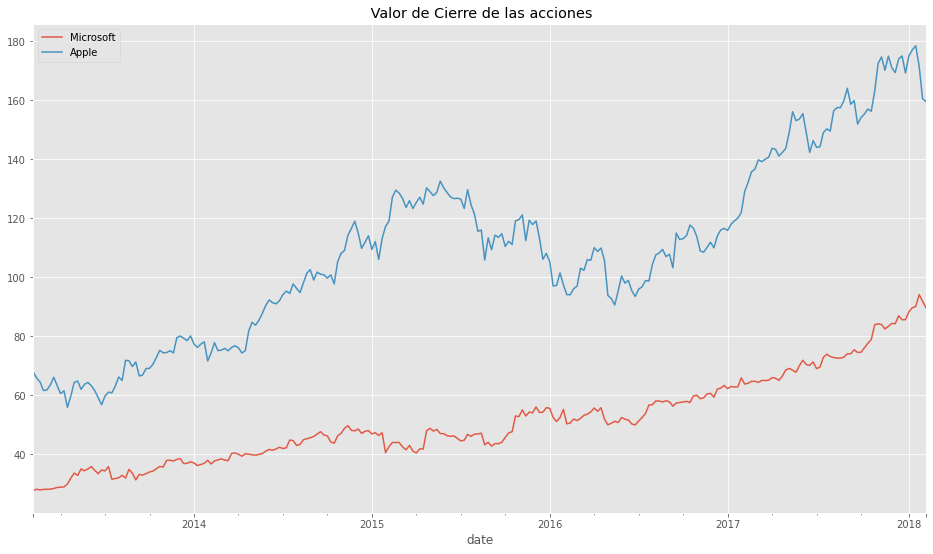

In [43]:
#Valor y cierre de las acciones
plot_stock('MSFT')#Microsoft
plot_stock('AAPL')#Apple
plt.title(' Valor de Cierre de las acciones')
plt.legend();

##Calcular los rendimientos para que podamos comparar las acciones

In [45]:
#df_acciones.head()
start = df.iloc[0]  #traemos la primera fila y la volvemos un vector
#calculamos el valor del retorno de la acción
returns = (df - start) / start
returns

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,ANDV,ANSS,...,UPS,URI,USB,UTX,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-02-17,-0.062777,-0.016949,0.001267,-0.031201,0.036690,-0.006185,0.019471,0.011595,-0.012398,0.010394,0.077763,0.004842,0.008632,0.002828,0.015946,0.012565,0.009033,-0.027668,-0.020060,-0.025272,-0.011343,0.019251,0.085062,0.023703,0.086674,0.044047,0.000000,0.006369,0.015729,-0.081678,0.009552,0.046332,0.010854,0.000410,-0.036418,0.034291,-0.024397,0.011987,0.014482,0.012451,...,0.013353,0.033528,0.007727,0.007659,0.001204,-0.014768,0.031694,0.003036,0.025146,-0.018723,0.004497,-0.000364,0.016523,0.030406,0.001127,0.000865,-0.006039,0.002062,-0.006990,0.008028,0.037365,0.010744,-0.024722,-0.030498,-0.017735,0.014565,-0.008015,-0.028138,-0.024775,0.009698,0.015227,0.016262,-0.002821,-0.001633,0.001256,0.043928,-0.020061,0.000659,0.008285,0.028139
2013-02-24,-0.072760,-0.080000,0.003929,-0.050886,0.060966,0.001280,0.004069,0.020325,-0.014571,-0.003939,0.062210,0.001395,-0.000389,-0.025199,0.029745,0.036123,0.014453,-0.059684,-0.005561,-0.045855,-0.008765,0.044102,0.079876,0.020016,0.023998,0.037344,-0.025970,0.043764,0.035445,-0.066410,-0.002939,0.007722,0.018813,-0.000546,0.000576,0.021657,-0.032961,0.013247,0.013739,0.022627,...,0.006798,-0.007158,0.006835,0.004440,0.010330,-0.013783,0.036006,-0.004386,-0.001301,-0.073466,0.009821,-0.008379,0.009033,0.040196,0.023675,0.001297,0.009903,-0.053413,0.007738,0.026950,0.020779,0.008540,-0.043333,-0.015109,-0.043656,-0.016220,-0.025213,-0.072558,0.033634,0.014009,0.026558,0.011997,0.006658,-0.025426,0.020101,0.025840,0.002297,-0.022544,-0.004143,-0.013918
2013-03-03,-0.069876,-0.077288,-0.032066,-0.093708,0.043034,0.023246,-0.023540,0.020597,0.018149,-0.010284,0.057909,0.011900,0.029206,-0.039342,0.039252,0.048014,0.077687,-0.061265,-0.003178,-0.021841,-0.024233,0.041652,0.084544,0.007638,0.034726,0.026013,-0.048885,0.076639,0.026805,-0.073564,-0.001470,-0.065637,0.000724,-0.002936,0.066959,0.023913,0.013885,0.014468,0.082250,0.026643,...,0.005948,-0.008665,0.010698,0.000444,0.001774,-0.003516,0.050055,0.006073,0.010839,-0.072932,-0.049698,0.074681,0.017184,0.056956,0.053439,0.013401,-0.001932,-0.006393,0.031203,0.014622,0.065505,0.016529,-0.060278,0.003637,-0.027285,-0.021185,0.013024,-0.078644,-0.016967,0.031250,0.020538,-0.022927,0.009254,-0.039888,0.023869,0.014766,-0.001378,-0.011338,-0.004143,0.046899
2013-03-10,-0.045475,0.011525,-0.026109,-0.091078,0.030069,0.033909,0.007847,0.068749,0.060838,0.007659,0.076770,0.039803,0.024468,0.032913,0.039252,0.065515,0.113821,-0.001581,-0.004171,0.001258,0.020366,0.064403,0.110996,0.020806,0.051383,0.047079,0.017110,0.181426,0.050510,-0.027760,-0.005143,-0.011583,0.023155,0.032229,0.071799,0.084223,0.001038,0.046726,0.084293,0.067613,...,0.025006,0.032209,0.017236,0.021978,0.018188,0.038256,0.063976,0.044366,-0.013657,-0.024251,-0.003195,0.087614,0.030623,0.043311,0.081398,0.021074,-0.018357,-0

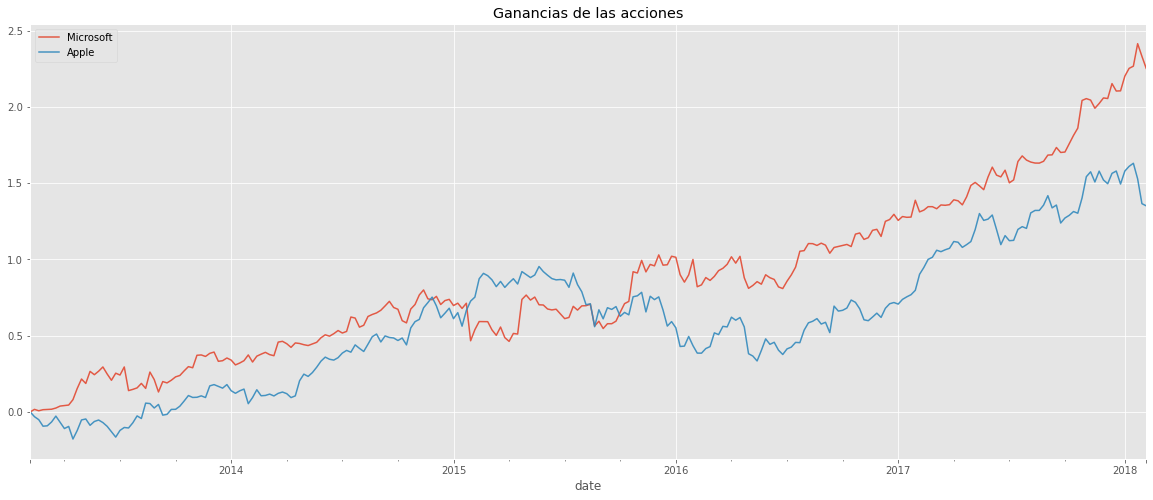

In [46]:
plt.figure(figsize = (20,8))
plot_stock('MSFT', df_acciones=returns)
plot_stock('AAPL', df_acciones=returns)
plt.title('Ganancias de las acciones')
plt.legend();

##¿Cuáles fueron las acciones de mejor y peor desempeño?

###Las mejores y las peores 5 empresas con retorno

In [47]:
best = returns.iloc[-1].sort_values(ascending=False).head() # traemos las acciones mejor ordenadas
worst = returns.iloc[-1].sort_values().head()   #traemos las acciones con el orden inverso (las peores)
print ('--------peores--> ', worst.shape)
print(worst)
print ('--------mejores--> ',best.shape)
print(best)

--------peores-->  (5,)
symbol
CHK     -0.857143
RRC     -0.818157
DISCA   -0.676508
DISCK   -0.660217
MOS     -0.588762
Name: 2018-02-11 00:00:00, dtype: float64
--------mejores-->  (5,)
symbol
NVDA    17.496362
NFLX     9.233321
ALGN     6.159487
EA       6.084053
STZ      5.723705
Name: 2018-02-11 00:00:00, dtype: float64


###Las mejores acciones

In [48]:
print('____mejor rendimiento de las acciones_____')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in best.index.tolist()]}, index = best.index)
best = pd.concat((best, names), axis=1)
best.head()

____mejor rendimiento de las acciones_____


,2018-02-11 00:00:00,name
symbol,,
NVDA,17.496362,Nvidia
NFLX,9.233321,Netflix
ALGN,6.159487,Align Technology
EA,6.084053,Electronic Arts
STZ,5.723705,Constellation Brands


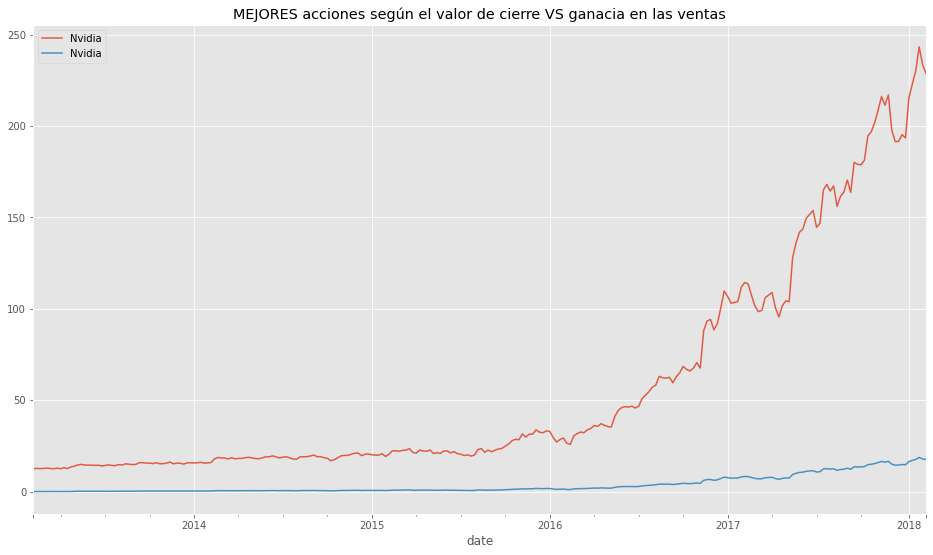

In [55]:
plot_stock('NVDA')##valor retorno
plot_stock('NVDA', df_acciones=returns)##VALOR cierre
plt.title('MEJORES acciones según el valor de cierre VS ganacia en las ventas')
plt.legend();

###Las peores acciones

In [49]:
print('Peores perdidas de acciones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in worst.index.tolist()]}, index = worst.index)
worst = pd.concat((worst, names), axis=1)
worst

Peores perdidas de acciones


,2018-02-11 00:00:00,name
symbol,,
CHK,-0.857143,No tiene nombre el simbolo
RRC,-0.818157,No tiene nombre el simbolo
DISCA,-0.676508,Discovery (Series A)
DISCK,-0.660217,Discovery (Series C)
MOS,-0.588762,The Mosaic Company


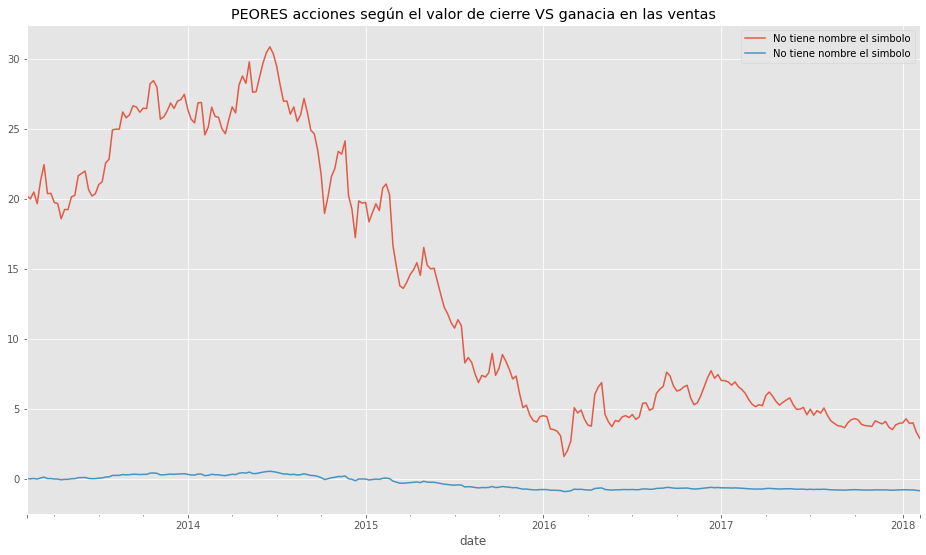

In [54]:
plot_stock('CHK')##valor retorno
plot_stock('CHK', df_acciones=returns)##valor cierre
plt.title('PEORES acciones según el valor de cierre VS ganacia en las ventas')
plt.legend();